In [1]:
%config InlineBackend.figure_format = 'retina'

from matplotlib import rcParams
rcParams['savefig.dpi'] = 100
rcParams['figure.dpi'] = 100
rcParams['font.size'] = 20

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee
import arviz as az
import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import mcmc, NUTS
from scipy.stats import norm
from chainconsumer import Chain, ChainConsumer, Truth, ChainConfig, PlotConfig
import tqdm

/usr/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#Constantes
k2 = 8*np.pi*6.67e-11
exp = np.exp
pi = np.pi
ln = np.log

In [4]:
#Modelos e Parâmetros Cosmológicos
def Omega_m(z):
    Om_0 = Omega_m0*(1 + z)**3
    return Om_0

def H_LCDM_Free(z, H0, Omega_m0):
    Omega_k0 = 0
    Omega_L = 1 - Omega_m0
    Omega_r0 = 0
    H_LCDMf = H0*(Omega_L + Omega_k0 * (1+z)**2 + Omega_m0* (1+z)**3 + Omega_r0*(1+z)**4)**(1/2)
    return H_LCDMf

def H_Novo_Free(z, H0, Omega_m0, alpha):
    Omega_L = 1 - Omega_m0
    H_Novof = H0*(Omega_m0*((1 + z)**(-alpha + 3) + (alpha/(3 - alpha)*((1 + z)**(-alpha + 3)-1))) + Omega_L)**(1/2)
    return H_Novof

In [5]:
#Dataframe

myfile_H = pd.read_csv(r'H(z).txt', header= None, sep='\s\s+', engine='python')
myfile_H.columns = ['z', 'H', 'error_H']
Hdata = pd.DataFrame(myfile_H)
print(Hdata)

         z      H  error_H
0   0.0700   69.0     19.6
1   0.0900   69.0     12.0
2   0.1200   68.6     26.2
3   0.1700   83.0      8.0
4   0.1790   75.0      4.0
5   0.1990   75.0      5.0
6   0.2000   72.9     29.6
7   0.2700   77.0     14.0
8   0.2800   88.8     36.6
9   0.3520   83.0     14.0
10  0.3802   83.0     13.5
11  0.4000   95.0     17.0
12  0.4004   77.0     10.2
13  0.4247   87.1     11.2
14  0.4497   92.8     12.9
15  0.4700   89.0     49.6
16  0.4783   80.9      9.0
17  0.4800   97.0     62.0
18  0.5930  104.0     13.0
19  0.6800   92.0      8.0
20  0.7810  105.0     12.0
21  0.8750  125.0     17.0
22  0.8800   90.0     40.0
23  0.9000  117.0     23.0
24  1.0370  154.0     20.0
25  1.3000  168.0     17.0
26  1.3630  160.0     33.6
27  1.4300  177.0     18.0
28  1.5300  140.0     14.0
29  1.7500  202.0     40.0
30  1.9650  186.5     50.4


<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_22184/3072781807.py:3: SyntaxWarning: invalid escape sequence '\s'
  myfile_H = pd.read_csv(r'H(z).txt', header= None, sep='\s\s+', engine='python')


In [6]:
zdados = Hdata['z']
Hdados = Hdata['H']
errodado = Hdata['error_H']

#Conferência de type
type(Hdados)

pandas.core.series.Series

In [7]:
erroz = errodado.values
type(erroz)

numpy.ndarray

In [8]:
#Parâmetros fixos true
H0_true = 67.66
Omega_m0_true = 0.311
alpha_true = 0.1

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(x_vals, y_vals, yerr=err, fmt=".", label="Observações", ms=5, lw=1)
ax.plot(x_vals, best_fit, label="Best Fit", c="#ff0000")
#ax.plot(x_vals, x_vals - 1, label="Truth", c="black", ls=":", lw=1)
plt.fill_between(x_vals, lower_fit, upper_fit, label="95% uncertainty", fc="#0288D1", alpha=0.1)
#plt.fill_between(x_vals, bounds[1, :], bounds[-2, :], label="68\% uncertainty", fc="#0288D1", alpha=0.4)
ax.legend(frameon=False, loc=2)
ax.set_xlabel("$z$"), ax.set_ylabel("$H_0$")


<>:3: SyntaxWarning: invalid escape sequence '\L'
<>:3: SyntaxWarning: invalid escape sequence '\L'
/tmp/ipykernel_22184/2681803651.py:3: SyntaxWarning: invalid escape sequence '\L'
  ax.plot(zdados, H_LCDM_Free(zdados, H0_true, Omega_m0_true), label="$H\Lambda CDM$", c='gray')


(Text(0.5, 0, '$z$'), Text(0, 0.5, '$H(z)$'))

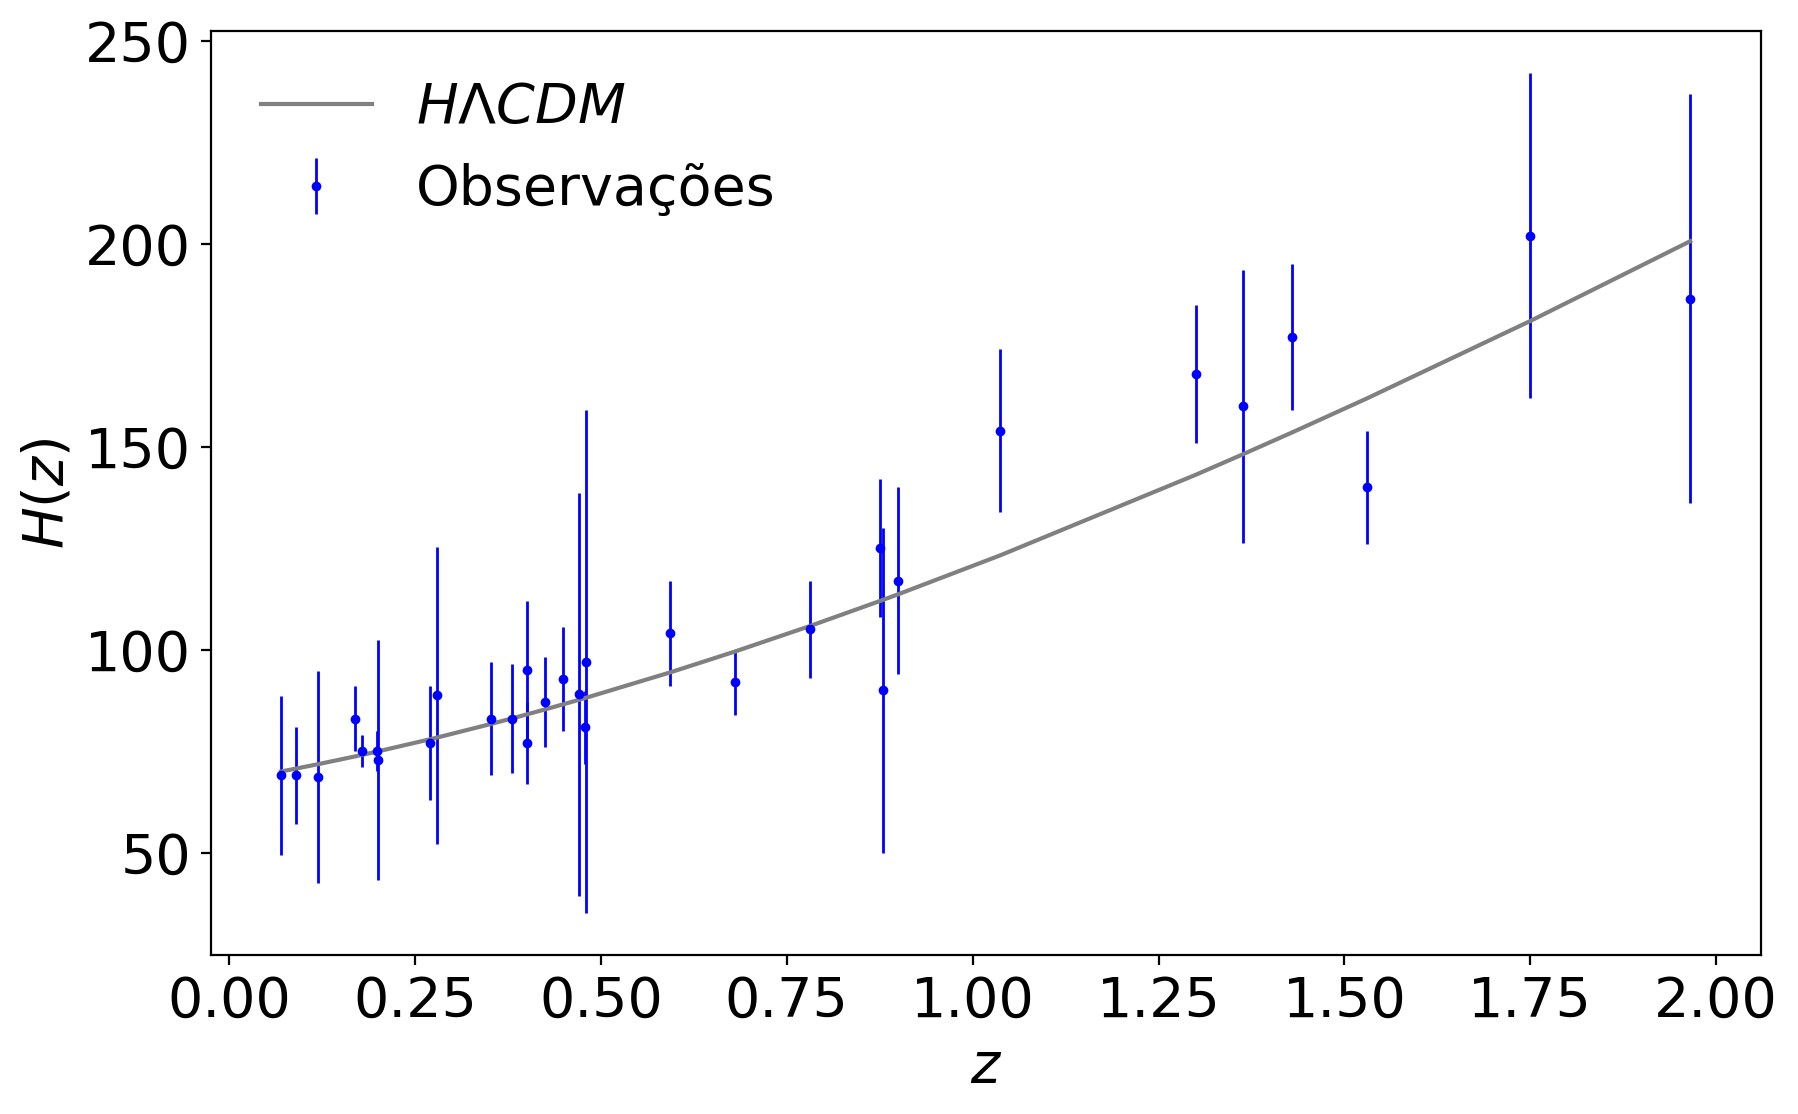

In [9]:
fig, ax = plt.subplots(figsize =(10,6))
ax.errorbar(zdados, Hdados, yerr=errodado, fmt='.', label='Observações', c = "b",ms=5, lw=1)
ax.plot(zdados, H_LCDM_Free(zdados, H0_true, Omega_m0_true), label="$H\Lambda CDM$", c='gray')
ax.legend(frameon=False, loc=2)
ax.set_xlabel("$z$"), ax.set_ylabel("$H(z)$")


Text(0, 0.5, 'H(z)')

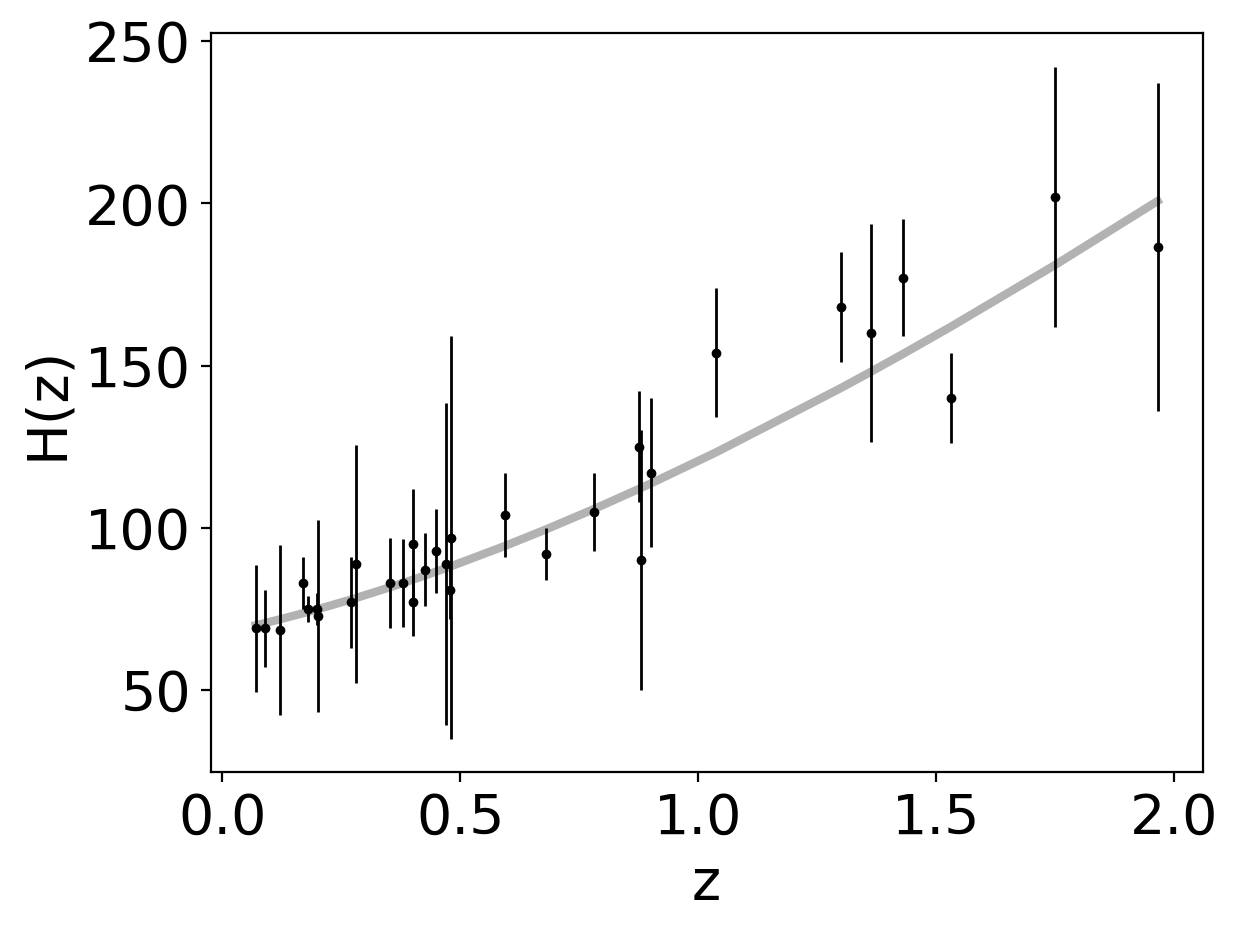

In [125]:
y = H_LCDM_Free(zdados, H0_true, Omega_m0_true)


plt.errorbar(zdados, Hdados, yerr=errodado, fmt='.k', label = "Observações",ms=5, lw=1, capsize=0)
x0= zdados
plt.plot(zdados, H_LCDM_Free(x0, H0_true, Omega_m0_true), 'k', alpha = 0.3, lw=3)
plt.xlabel('z')
plt.ylabel('H(z)')

<>:13: SyntaxWarning: invalid escape sequence '\L'
<>:13: SyntaxWarning: invalid escape sequence '\L'
/tmp/ipykernel_5897/1548421570.py:13: SyntaxWarning: invalid escape sequence '\L'
  ax.plot(zdados, H_LCDM_Free(zdados, H0_true, Omega_m0_true), label="$H\Lambda CDM$", c='gray')


Estimativa de Mínimos Quadrados
H0= 63.661 ± 2.214
Omega_m0= 60.381 ± 1.499


(Text(0.5, 0, '$z$'), Text(0, 0.5, '$H(z)$'))

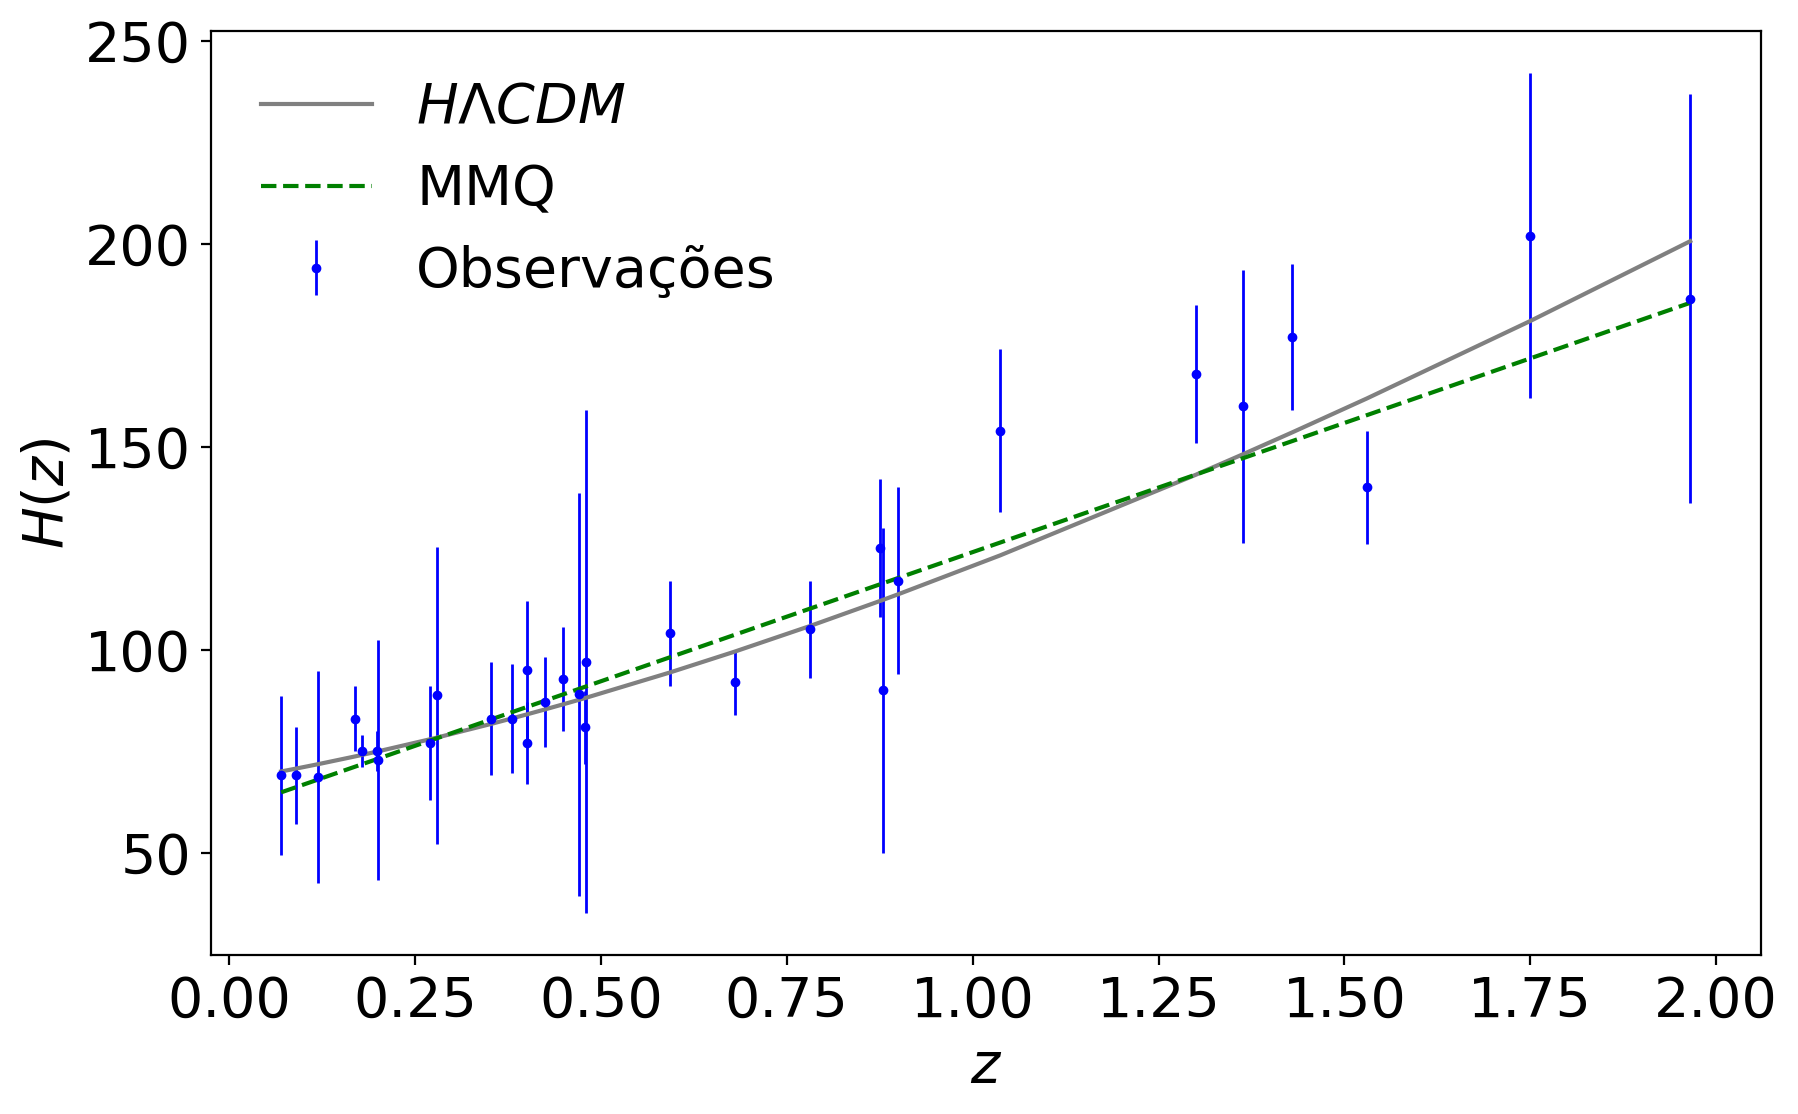

In [169]:
A = np.vander(zdados, 2)
C = np.diag(erroz*erroz)

ATA = np.dot(A.T, A/(erroz*2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y/(erroz*2)))
print('Estimativa de Mínimos Quadrados')
print("H0= {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0,0])))
print("Omega_m0= {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1,1])))

fig, ax = plt.subplots(figsize =(10,6))
ax.errorbar(zdados, Hdados, yerr=errodado, fmt='.', label='Observações',c = "b", ms=5, lw=1)
ax.plot(zdados, H_LCDM_Free(zdados, H0_true, Omega_m0_true), label="$H\Lambda CDM$", c='gray')
ax.plot(zdados, np.dot(np.vander(zdados,2), w), "--",c = 'green',  label='MMQ')
ax.legend(frameon=False, loc=2)
ax.set_xlabel("$z$"), ax.set_ylabel("$H(z)$")


Estimativa de Mínimos Quadrados
H0= 63.661 ± 2.214
Omega_m0= 60.381 ± 1.499


Text(0, 0.5, 'H(z)')

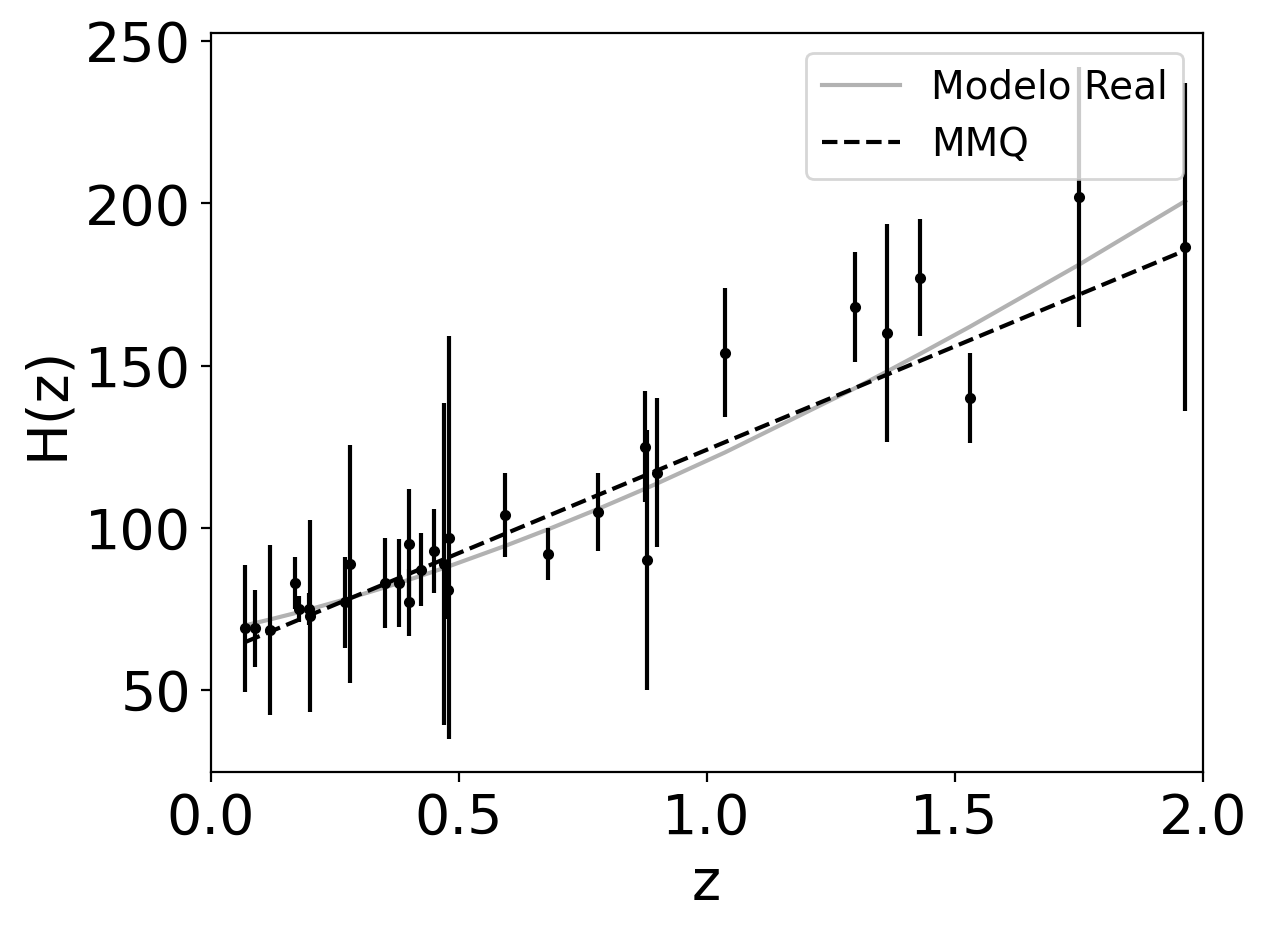

In [129]:
A = np.vander(zdados, 2)
C = np.diag(erroz*erroz)

ATA = np.dot(A.T, A/(erroz*2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y/(erroz*2)))
print('Estimativa de Mínimos Quadrados')
print("H0= {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0,0])))
print("Omega_m0= {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1,1])))

plt.errorbar(zdados, Hdados, yerr=erroz, fmt=".k", capsize=0)
plt.plot(zdados, H_LCDM_Free(x0, H0_true, Omega_m0_true), "k", alpha=0.3, label="Modelo Real")
plt.plot(zdados, np.dot(np.vander(x0, 2), w), "--k", label="MMQ")
plt.legend(fontsize=14)
plt.xlim(0, 2)
plt.xlabel("z")
plt.ylabel("H(z)")


<>:23: SyntaxWarning: invalid escape sequence '\L'
<>:23: SyntaxWarning: invalid escape sequence '\L'
/tmp/ipykernel_5897/3349427464.py:23: SyntaxWarning: invalid escape sequence '\L'
  ax.plot(zdados, H_LCDM_Free(zdados, H0_true, Omega_m0_true), label="$H\Lambda CDM$", c='gray')


Máxima Verossimilhança
H0 = 69.596
Omega_m0 = 0.292


(Text(0.5, 0, '$z$'), Text(0, 0.5, '$H_0$'))

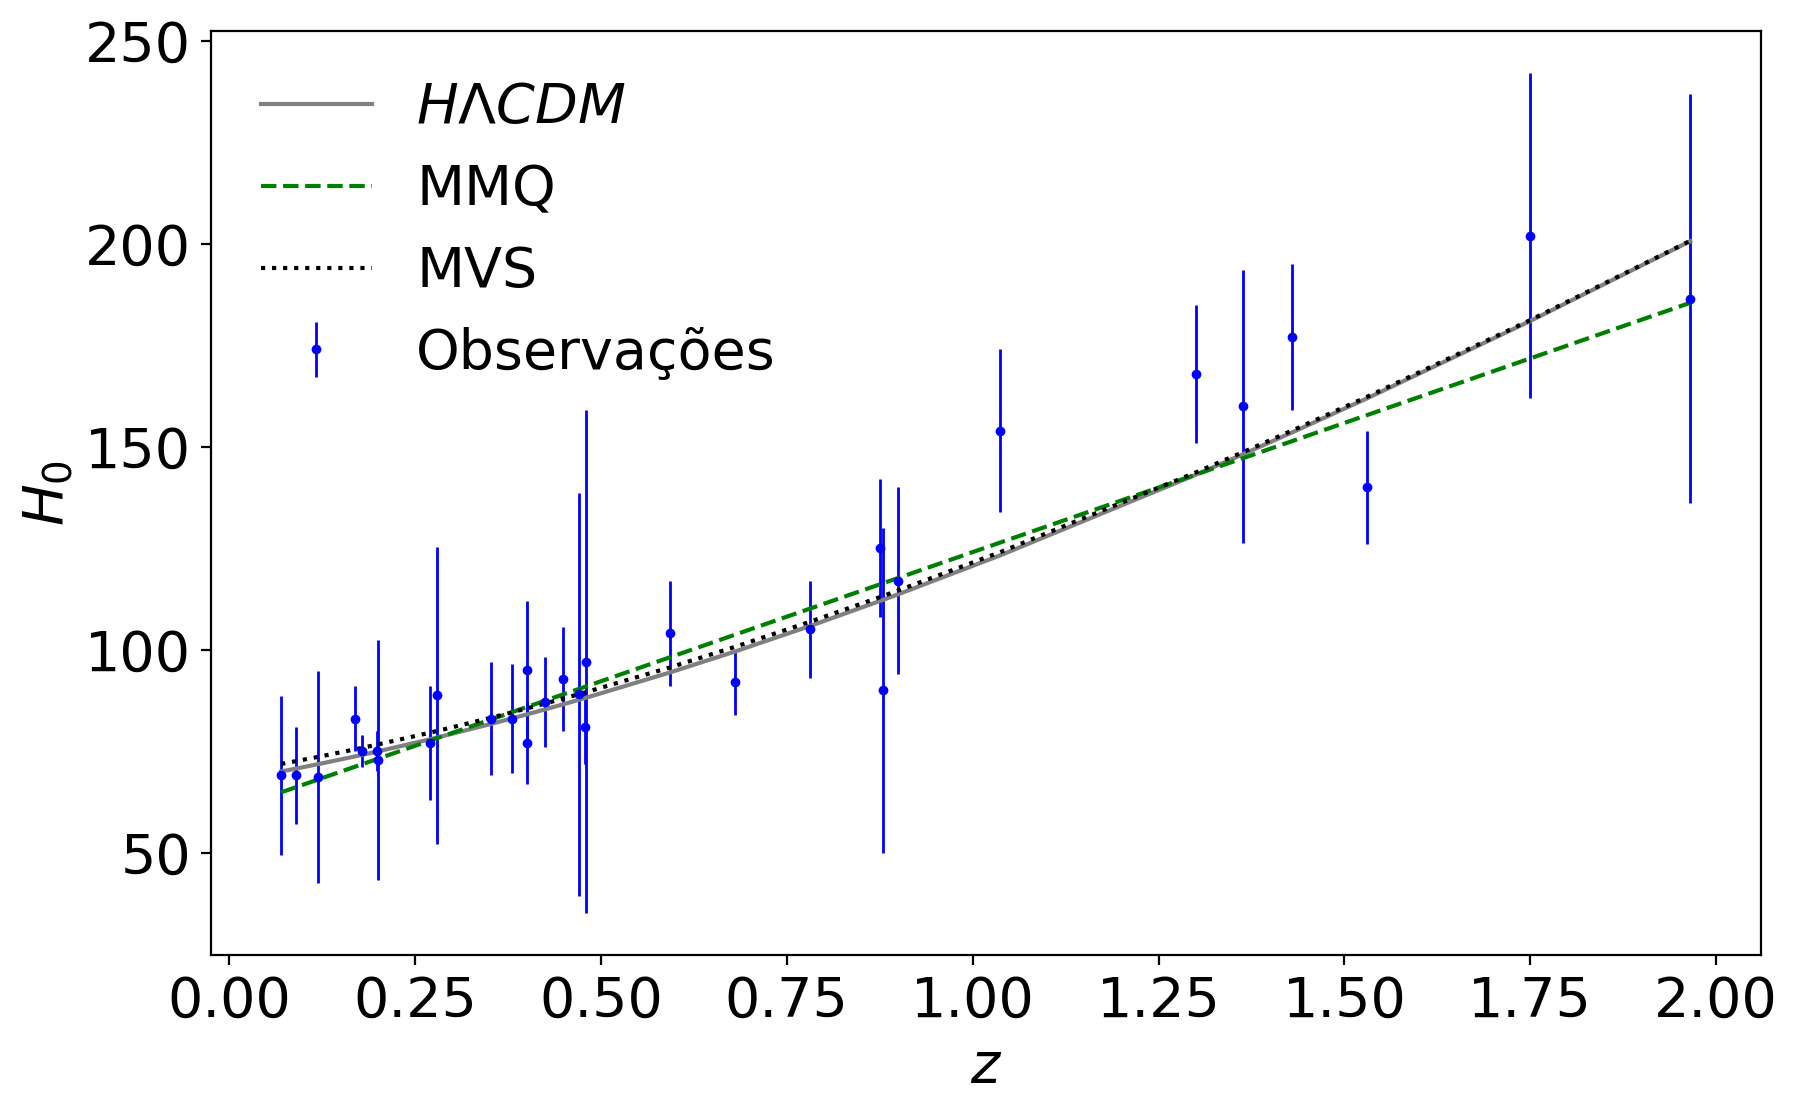

In [168]:
from scipy.optimize import minimize

def log_likelihood(theta, x, y, yerr):
    H0, Omega_m0 = theta
    model = H_LCDM_Free(x, H0, Omega_m0)
    sigma2 = yerr**2
    chi = ((y - model)**2)/sigma2
    return -0.5*np.sum((chi**2)+np.log(sigma2))

nll = lambda *args: - log_likelihood(*args)

initial = np.array([67.66,0.3])
soln = minimize(nll, initial, args=(zdados, Hdados, errodado))
H0_ml, Omega_ml = soln.x

print("Máxima Verossimilhança")
print("H0 = {0:.3f}".format(H0_ml))
print("Omega_m0 = {0:.3f}".format(Omega_ml))


fig, ax = plt.subplots(figsize =(10,6))
ax.errorbar(zdados, Hdados, yerr=errodado, fmt='.', label='Observações',c = "b", ms=5, lw=1)
ax.plot(zdados, H_LCDM_Free(zdados, H0_true, Omega_m0_true), label="$H\Lambda CDM$", c='gray')
ax.plot(zdados, np.dot(np.vander(zdados,2), w), "--",c = 'green',  label='MMQ')
ax.plot(zdados, H_LCDM_Free(zdados, H0_ml, Omega_ml), ":",c = "black", label="MVS")
ax.legend(frameon=False, loc=2)
ax.set_xlabel("$z$"), ax.set_ylabel("$H_0$")

Máxima Verossimilhança
H0 = 69.596
Omega_m0 = 0.292


Text(0, 0.5, 'H(z)')

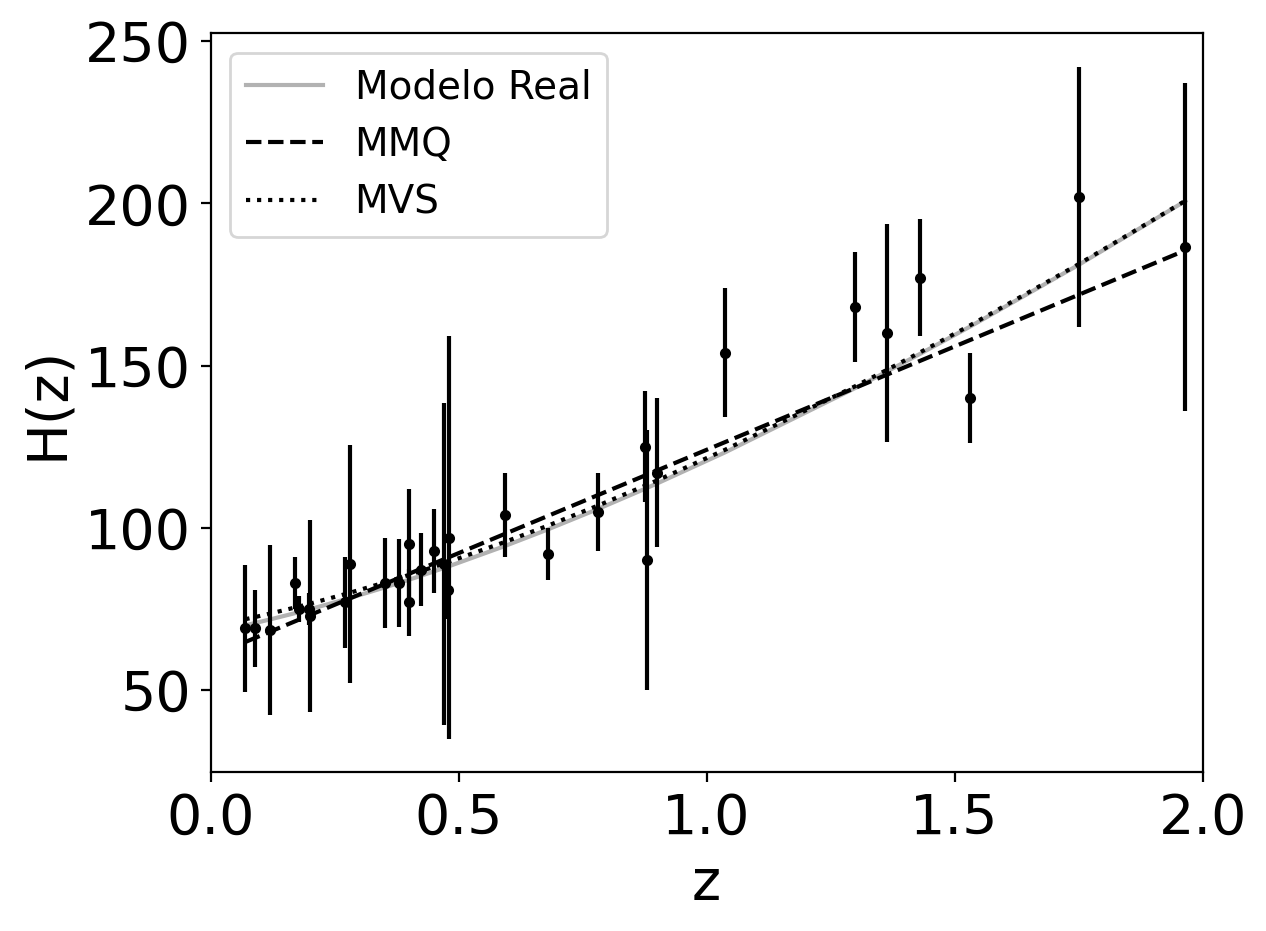

In [12]:
from scipy.optimize import minimize

def log_likelihood(theta, x, y, yerr):
    H0, Omega_m0 = theta
    model = H_LCDM_Free(x, H0, Omega_m0)
    sigma2 = yerr**2
    chi = ((y - model)**2)/sigma2
    return -0.5*np.sum((chi**2)+np.log(sigma2))

nll = lambda *args: - log_likelihood(*args)

initial = np.array([67.66,0.3])
soln = minimize(nll, initial, args=(zdados, Hdados, errodado))
H0_ml, Omega_ml = soln.x

print("Máxima Verossimilhança")
print("H0 = {0:.3f}".format(H0_ml))
print("Omega_m0 = {0:.3f}".format(Omega_ml))

plt.errorbar(zdados, Hdados, yerr=errodado, fmt=".k", capsize=0)
plt.plot(zdados, H_LCDM_Free(zdados, H0_true, Omega_m0_true), "k", alpha=0.3, label="Modelo Real")
plt.plot(zdados, np.dot(np.vander(zdados, 2), w), "--k", label="MMQ")
plt.plot(zdados, H_LCDM_Free(zdados, H0_ml, Omega_ml), ":k", label="MVS")
plt.legend(fontsize=14)
plt.xlim(0,2)
plt.xlabel("z")
plt.ylabel("H(z)")

In [13]:
def log_prior(theta): #pior seria a função de probabilidade para estimar os parâmetros?
    #H0, Omega_m0, log_alpha = theta
    H0, Omega_m0 = theta
    if 60.0 < H0 < 80.0 and 0.2 < Omega_m0 < 0.38: #and -10.0 < log_alpha < 1.0:
        return 0.0
    return -np.inf


def log_probability(theta, x, y, yerr): #Se sim, pq eu defini uma log probibilidade aqui?
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [14]:
import emcee

pos = soln.x + 1e-4*np.random.randn(32, 2)
nwalkers, ndim = pos.shape #O que quer dizer esse método shape?

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(zdados, Hdados, errodado))
sampler.run_mcmc(pos, 8000, progress=True)

100%|██████████| 8000/8000 [11:02<00:00, 12.08it/s]


State([[71.8153176   0.26030056]
 [67.74846548  0.31971743]
 [69.17711044  0.30233583]
 [68.13535889  0.33565799]
 [69.07542524  0.30294399]
 [68.79986888  0.31543496]
 [68.76329252  0.29947509]
 [69.57633465  0.28580043]
 [68.36403476  0.30784503]
 [71.89224458  0.26928317]
 [66.13344738  0.3300685 ]
 [68.7722815   0.29853268]
 [67.2810772   0.32915002]
 [70.06607336  0.28760073]
 [70.78340498  0.28841766]
 [69.05987769  0.29834432]
 [64.97487727  0.35208947]
 [67.3248052   0.31259113]
 [71.63200059  0.25380187]
 [67.35415173  0.31514383]
 [65.79357995  0.35025887]
 [70.66127247  0.26799869]
 [70.11461612  0.27291044]
 [70.29099249  0.28189523]
 [68.01345272  0.31349177]
 [65.83657623  0.33894436]
 [67.88446527  0.31316202]
 [72.43269591  0.26458749]
 [68.74422547  0.30320466]
 [68.32466225  0.31166754]
 [67.63635456  0.31162868]
 [72.98510707  0.23187585]], log_prob=[-100.2733093   -99.93146062  -99.71011522 -102.54936147  -99.68914229
 -100.45422922  -99.65982414  -99.76470452  -99.

In [31]:
#Comentar essa célula pq é a que deu certo

#params = [r'$H_0$', r'$\Omega_{m}$']
#chain = Chain.from_emcee(sampler, params, "Truth", discard = 40, thin=2, color='indigo')
#consumer = ChainConsumer().add_chain(chain)

<>:16: SyntaxWarning: invalid escape sequence '\O'
<>:16: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipykernel_5897/2732407589.py:16: SyntaxWarning: invalid escape sequence '\O'
  c.set_plot_config(PlotConfig(labels={"H0": "$H_0$", "Omega_m": "$\Omega_{m}$"}))


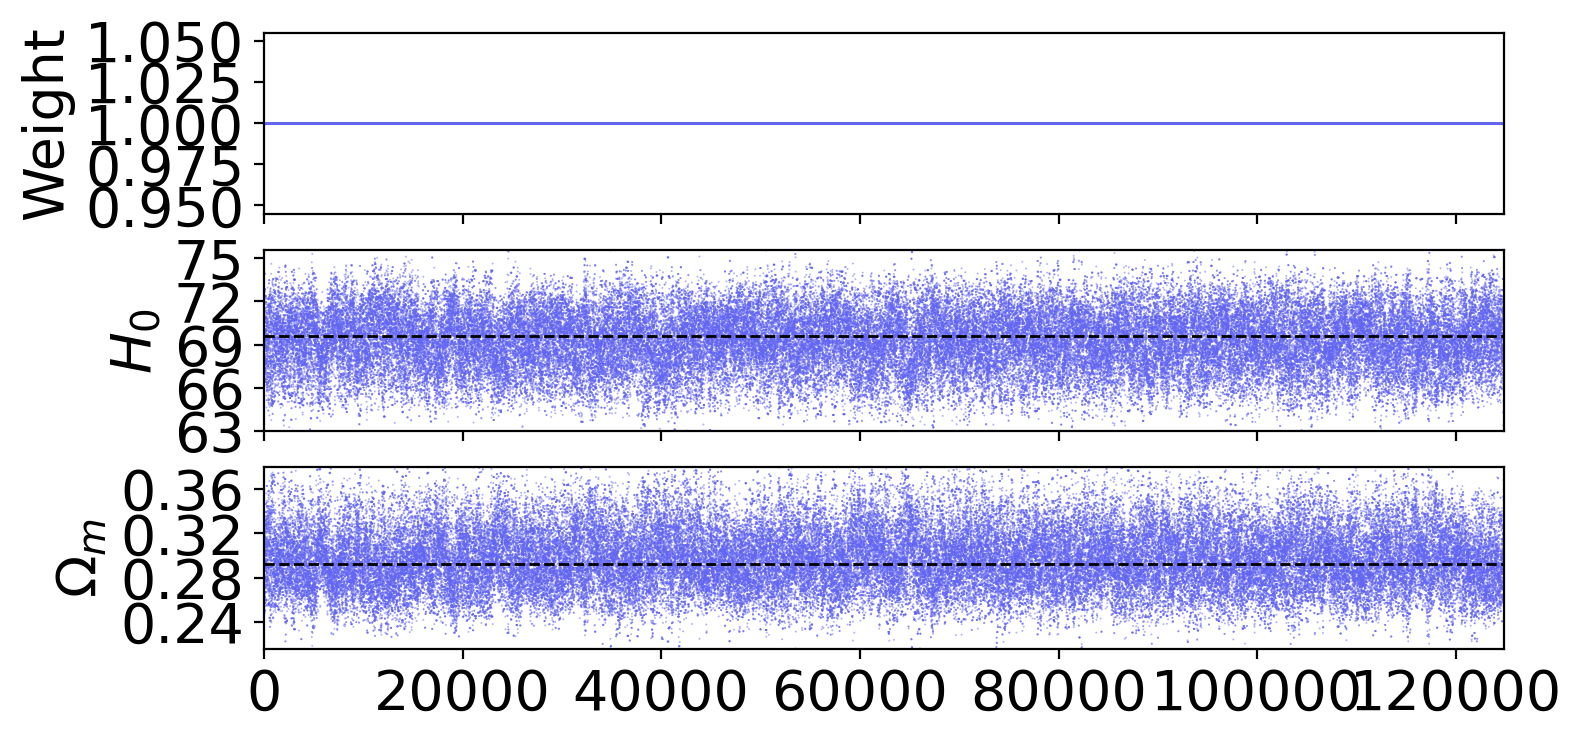

In [160]:
chain = Chain.from_emcee(
    sampler,
    columns=["H0", "Omega_m"],
    name ="Cadeia",
    discard = 200,
    color='indigo',
    summary_area=0.95,
        show_contour_labels=True)


truth = Truth(location={'H0': H0_ml, 'Omega_m': Omega_ml}, color='black')
c = ChainConsumer()
c.add_chain(chain)
#consumer.add_marker(location={'H0': H0_ml, 'Omega_m': Omega_ml}, name='MLH', color='orange', marker_style='P', marker_size=50)
c.add_truth(truth)
c.set_plot_config(PlotConfig(labels={"H0": "$H_0$", "Omega_m": "$\Omega_{m}$"}))
#consumer.add_chain(sampler.chain.reshape((-1, ndim==2)), color='r')
fig = c.plotter.plot_walks(plot_weights=True,figsize=(8,4))

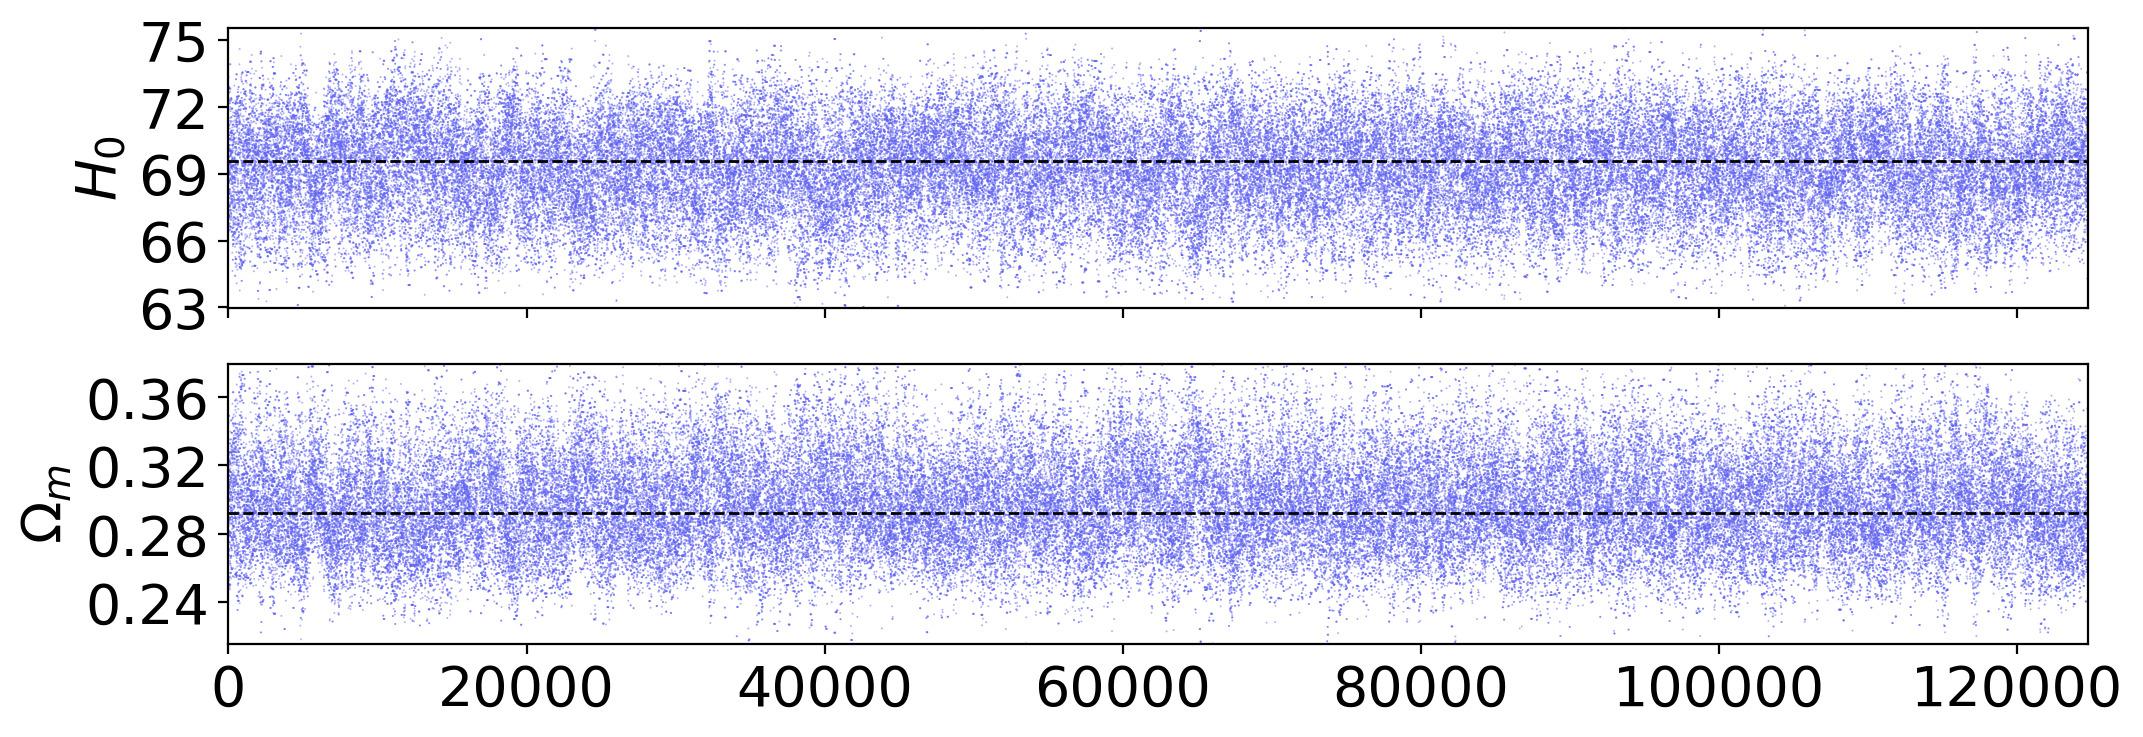

In [161]:
fig2 = c.plotter.plot_walks(plot_weights=None,figsize=(12,4))

In [162]:
c.add_marker(location={'H0': H0_ml, 'Omega_m': Omega_ml}, name='MLH', color='orange', marker_style='P', marker_size=50)
#consumer.add_truth(Truth(location={'H_0': H0_ml, 'Omega_m': Omega_ml}))


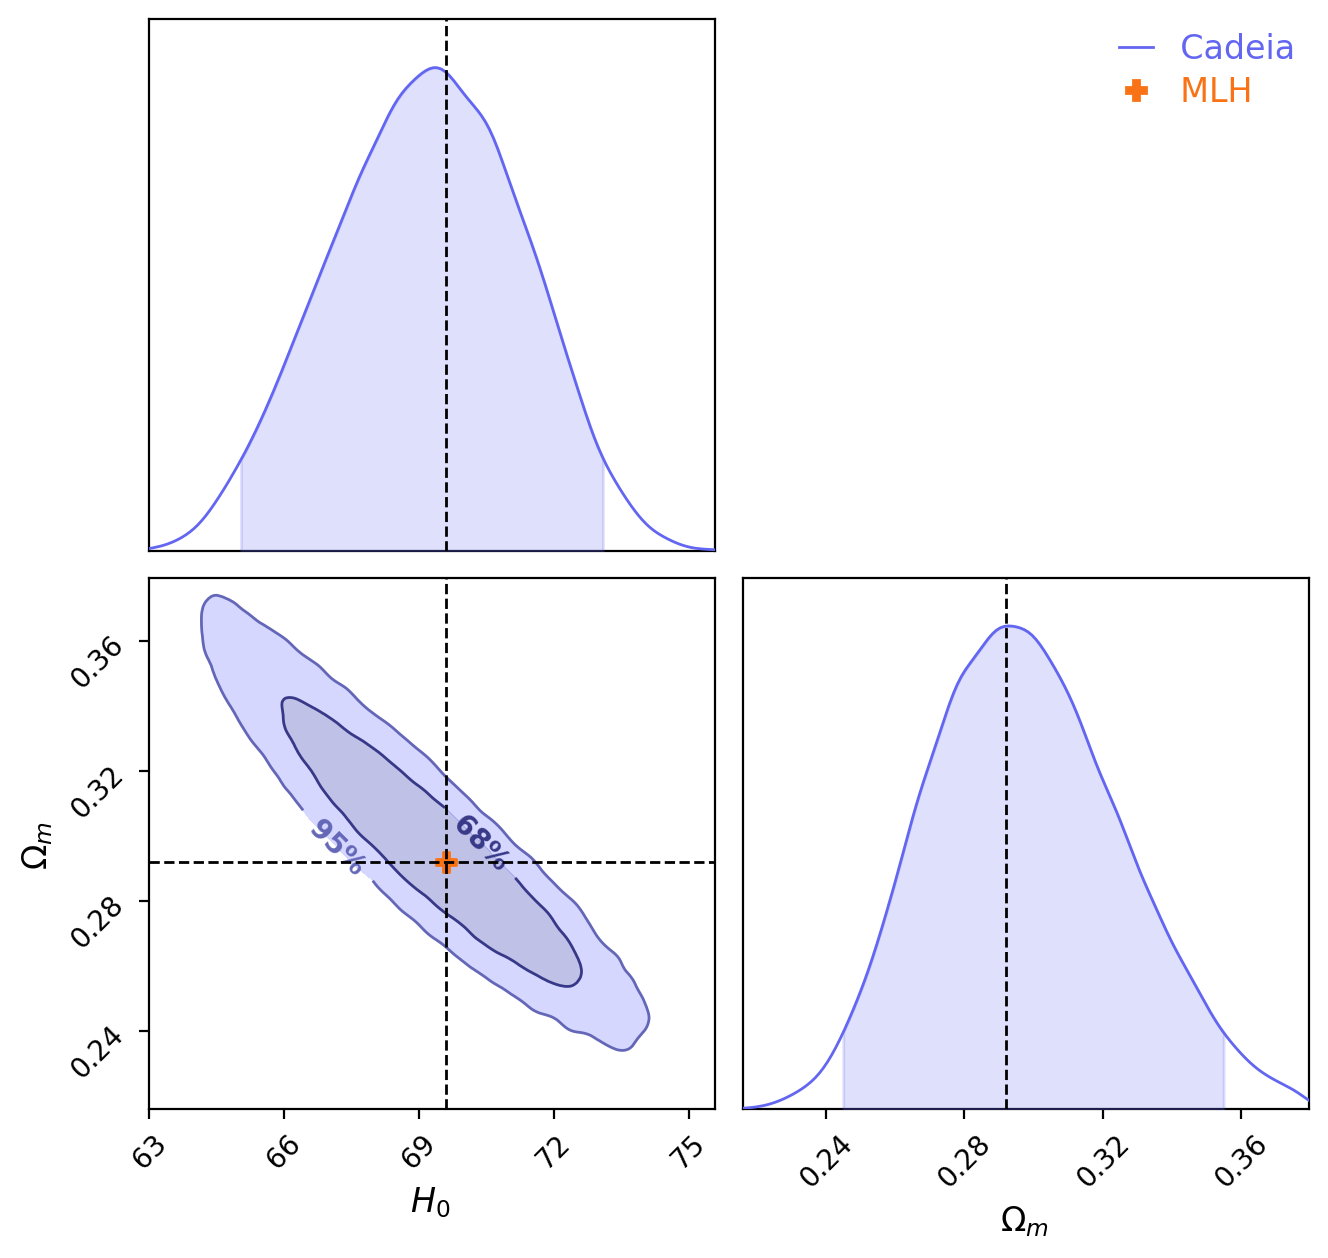

In [163]:
#consumer.set_plot_config(plot_config)

fig = c.plotter.plot()

In [113]:
summary = c.analysis.get_summary()["Cadeia"]

In [114]:
print(summary)

{'H0': Bound(lower=65.04019749134093, center=69.39908023538763, upper=73.0956031812034), 'Omega_m': Bound(lower=0.2449621306280943, center=0.2923649099578792, upper=0.3549196491091489)}


In [115]:
print(summary['H0'].center)
print(summary['Omega_m'].center)

69.39908023538763
0.2923649099578792


In [116]:
x_vals = zdados.values

H0_best = summary['H0'].center
Omega_m_best = summary['Omega_m'].center
H0_lower = summary['H0'].lower
Omega_m_lower = summary['Omega_m'].lower
H0_upper = summary['H0'].upper
Omega_m_upper = summary['Omega_m'].upper

best_fit = H_LCDM_Free(x_vals, H0_best, Omega_m_best)
lower_fit = H_LCDM_Free(x_vals, H0_lower, Omega_m_lower)
upper_fit = H_LCDM_Free(x_vals, H0_upper, Omega_m_upper)


#gradients = np.tan(chain.samples['H0'].to_numpy())
#offsets = chain.samples['Omega_m'].to_numpy()
#realisations = gradients[:, None]*x_vals[None, :] + offsets[:, None]
#bounds = np.quantile(realisations, norm.cdf([-2, -1, 1, 2]), axis=0)



In [117]:
type(zdados)
y_vals = Hdados.values
err = errodado.values

(Text(0.5, 0, '$z$'), Text(0, 0.5, '$H_0$'))

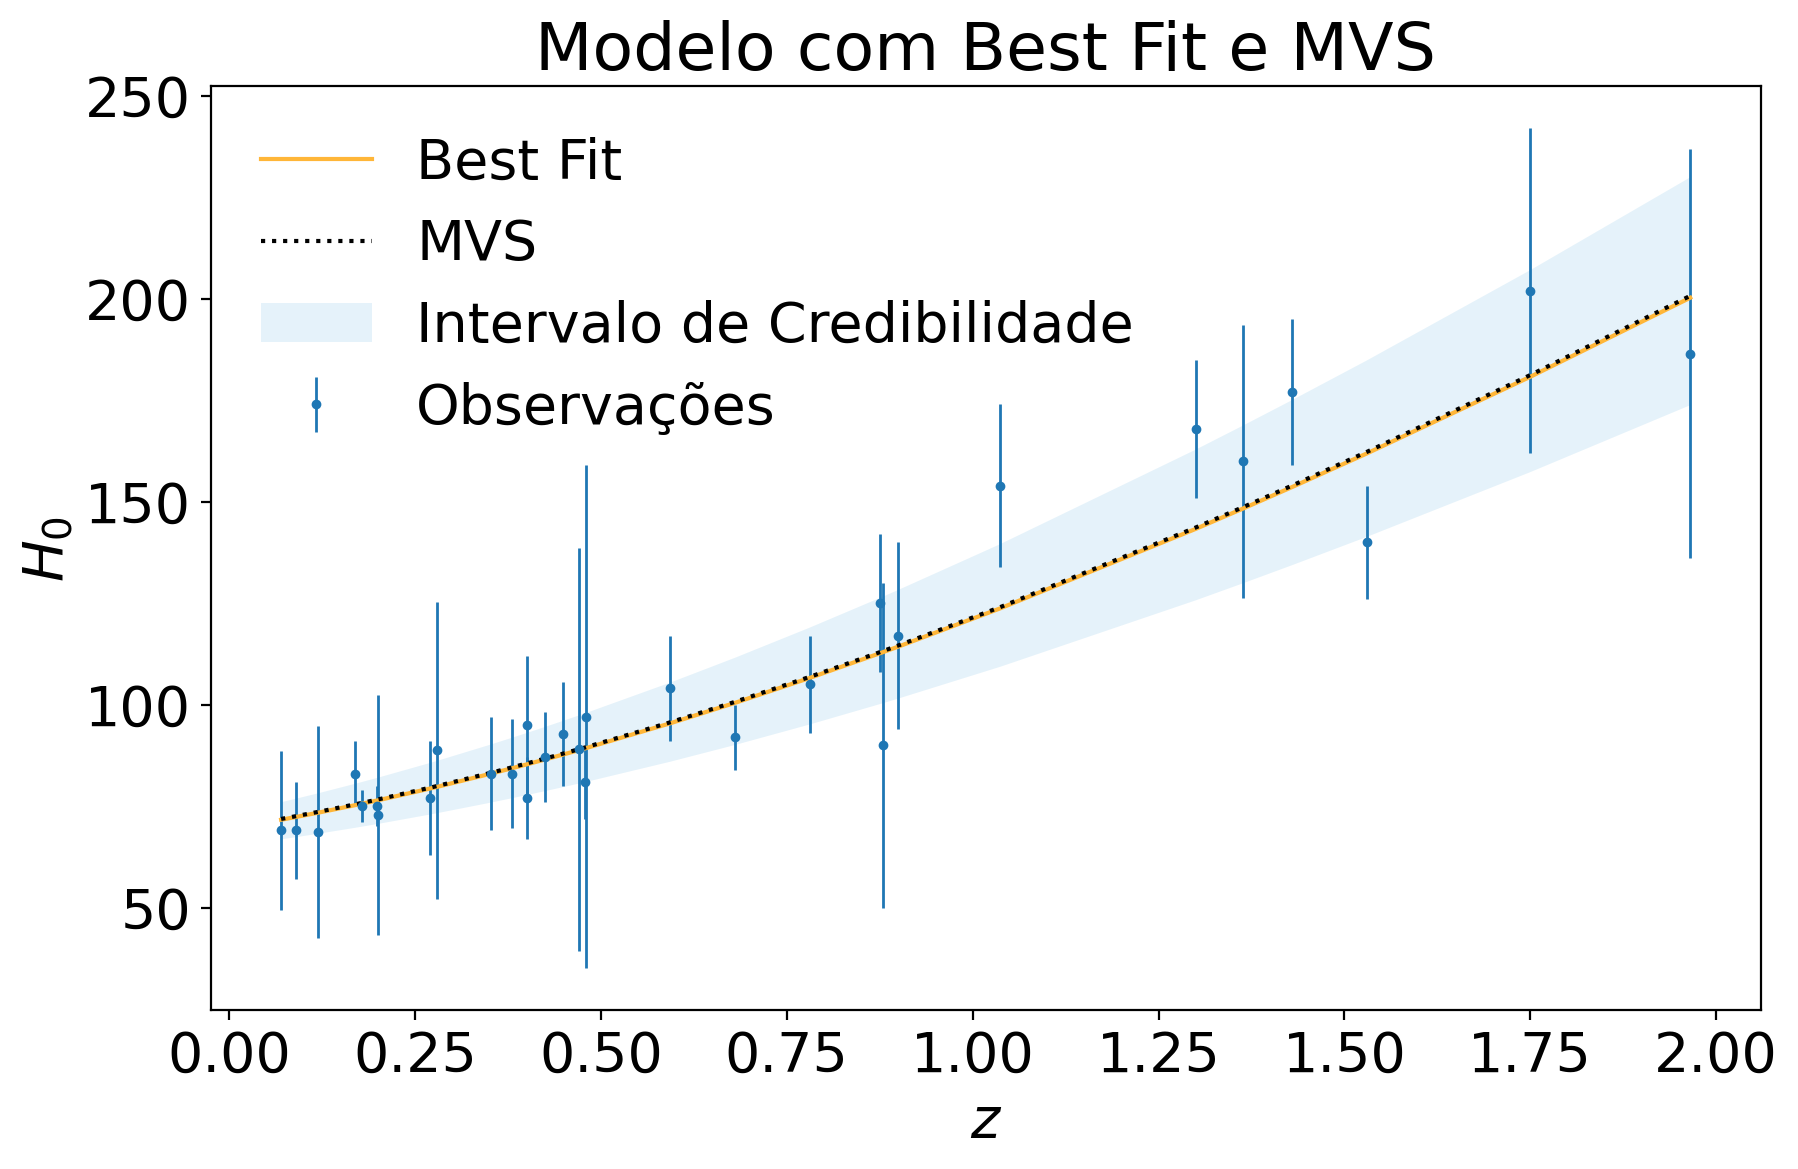

In [170]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(x_vals, y_vals, yerr=err, fmt=".", label="Observações", ms=5, lw=1)
ax.plot(x_vals, best_fit, label="Best Fit", c="#ffb638")
ax.plot(x_vals, H_LCDM_Free(zdados, H0_ml, Omega_ml),':', label='MVS',c='black')
#ax.plot(x_vals, x_vals - 1, label="Truth", c="black", ls=":", lw=1)
plt.fill_between(x_vals, lower_fit, upper_fit, label="Intervalo de Credibilidade", fc="#0288D1", alpha=0.1)
#plt.fill_between(x_vals, bounds[1, :], bounds[-2, :], label="68\% uncertainty", fc="#0288D1", alpha=0.4)
ax.legend(frameon=False, loc=2)
plt.title("Modelo com Best Fit e MVS")
ax.set_xlabel("$z$"), ax.set_ylabel("$H_0$")

